# Module Import / Setting

!git clone https://github.com/moskomule/sam.pytorch.git \
!https://github.com/marcellodebernardi/loss-landscapes.git 참고 \
two devices 관련 오류 뜨면 해당 파일로 가서 parameter.to(torch.device('cuda'))

In [1]:
import os
import numpy as np
import random

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns

import torch
import torch.nn as nn  
from torch.utils import data
import torchvision
from torchvision import transforms
import timm

# from sampytorch.sam import SAMSGD 

import copy
import yaml

import loss_landscapes

import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import wrap_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)
print(f'Number of cuda available: {torch.cuda.device_count()}')

Using PyTorchversion: 1.8.0.dev20201207+cu101 Device: cuda
Number of cuda available: 3


# Hyperparameter Loading

In [4]:
PATH = 'home/ViT_SAM/results/vit_small_patch32_224/sam/2022-12-05-18-59-08/model-epoch01-loss_val0.72-acc_val0.58.pt'

In [5]:
path = f'./results/{PATH[21:]}'

split = path.split('/')
model_name = split[2]
opt_name = split[3]
run_path = f'./results/{model_name}/{opt_name}/{split[4]}/'
config_path = f'./results/{model_name}/{opt_name}/{split[4]}/config.yaml'

model_name, opt_name

('vit_small_patch32_224', 'sam')

In [6]:
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

for var in config.split('--'):
    if 'batch_size' in var:
        BATCH_SIZE = int(var[11:])

BATCH_SIZE

64

In [7]:
config.split('--')

['',
 'path_to_data ./Data ',
 'pretrained_path False ',
 'arch vit_small_patch32_224 ',
 'optimizer SGD ',
 'optimizer_plus sam ',
 'batch_size 64 ',
 'lr 0.001 ',
 'momentum 0.05 ',
 'patience 5 ',
 'n_epochs 100']

# Load Data

In [8]:
DATA_DIR = './Data/'
IMG_SIZE = 224

In [9]:
## LOAD DATA ##
resized_normal_arr = np.load(f'./Data/{IMG_SIZE}_normal_arr.npy')
resized_opacity_arr = np.load(f'./Data/{IMG_SIZE}_opacity_arr.npy')

In [10]:
## PREPROCESS ##
X_data = np.concatenate((resized_normal_arr, resized_opacity_arr))
y_data = []

for i in range(len(resized_normal_arr)):
    y_data.append(0)
    
for i in range(len(resized_opacity_arr)):
    y_data.append(1)
    
X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state = 71, stratify = y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state = 71, stratify = y_train)

In [11]:
class Dataset(data.Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = self.images[index]
        label = int(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)

In [23]:
X_train = X_train[:int(len(X_train)/10)]
y_train = y_train[:int(len(y_train)/10)]

In [24]:
train_dataset = Dataset(X_train, y_train, transform = transforms.ToTensor())
val_dataset = Dataset(X_val, y_val, transform = transforms.ToTensor())
test_dataset = Dataset(X_test, y_test, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = True)   
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = False)

# Load Initial Model & Trained Model

In [25]:
## Model ##
model = timm.create_model(model_name, pretrained=False)

if 'resnet' in model_name:
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,2)
    model.fc = nn.Sequential(model.fc, nn.Softmax(),)

elif 'vit' in model_name:
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs,2)
    model.head = nn.Sequential(model.head, nn.Softmax(),)
    
model = model.to(DEVICE)
model_initial = copy.deepcopy(model)

In [26]:
## Loss ##
criterion = torch.nn.CrossEntropyLoss()

In [27]:
## LOAD PRETRAINED MODEL ##
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

model_final = copy.deepcopy(model)


# Loss Landscape

## By Script

In [4]:
!python landscape.py --path_to_model home/ViT_SAM/results/vit_small_patch32_224/sam/2022-12-05-11-05-31/model-epoch01-loss_val0.71-acc_val0.59.pt

Data directory:  ./Data/
Batch size:  32
Image size:  224
Figure(640x480)
Figure(640x480)
Done. Check ./results/vit_small_patch32_224/sam/2022-12-05-11-05-31/


## By Function

In [30]:
from get_landscape import get_landscape

In [31]:
save_path = run_path

In [ ]:
get_landscape(model_initial, model_final, criterion, train_loader, save_path, DEVICE = DEVICE, STEPS = 40)

In [36]:
import ops.loss_landscapes as lls

scale = 1e-0
n = 21
gpu = torch.cuda.is_available()

metrics_grid = lls.get_loss_landscape(
    model, 1, train_loader, transform=None,
    kws=["pos_embed", "relative_position"],
    x_min=-1.0 * scale, x_max=1.0 * scale, n_x=n, y_min=-1.0 * scale, y_max=1.0 * scale, n_y=n, gpu=gpu,
)


Grid:  [-1. -1.], NLL: 0.7006, Cutoffs: 0.0 %, 90.0 %, Accs: 52.542 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 26.271 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 100.000 %, Brier: 0.505, ECE: 9.379 %, ECE±: 9.379 %
Grid:  [-0.9 -1. ], NLL: 0.7034, Cutoffs: 0.0 %, 90.0 %, Accs: 52.542 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 26.271 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 100.000 %, Brier: 0.507, ECE: 9.986 %, ECE±: 9.986 %
Grid:  [-0.8 -1. ], NLL: 0.7044, Cutoffs: 0.0 %, 90.0 %, Accs: 52.542 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 26.271 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 100.000 %, Brier: 0.510, ECE: 10.666 %, ECE±: 10.666 %
Grid:  [-0.7 -1. ], NLL: 0.7065, Cutoffs: 0.0 %, 90.0 %, Accs: 52.542 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 26.271 %, 0.000 %, Freqs: 100.000 %, 0.000 %, Top-5: 100.000 %, Brier: 0.512, ECE: 11.129 %, ECE±: 11.129 %
Grid:  [-0.6 -1. ], NLL: 0.7077, Cutoffs: 0.0 %, 90.0 %, Accs: 53.390 %, 0.000 %, Uncs: 0.000 %, 100.000 %, IoUs: 26.6

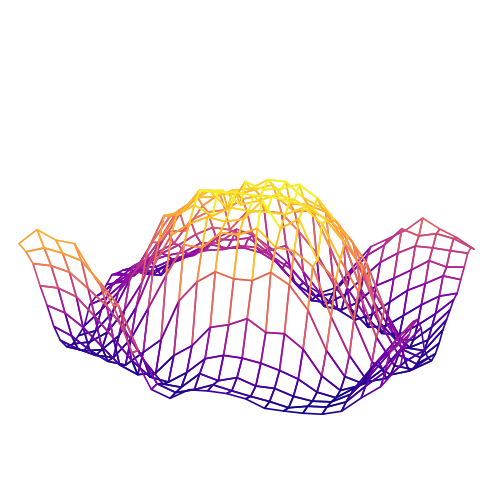

In [40]:
from pathlib import Path
import ops.tests as tests

# dataset_name = 'CXR'
# uid = "691cc9a9e4"

# leaderboard_path = os.path.join("leaderboard", "logs", dataset_name, model_name)
# Path(leaderboard_path).mkdir(parents=True, exist_ok=True)
metrics_dir = os.path.join(run_path,'scale-%s_n-%s_loss_landscape_HDVW.csv' % (int(1 / scale),n))
metrics_list = [[*grid, *metrics] for grid, metrics in metrics_grid.items()]
tests.save_metrics(metrics_dir, metrics_list)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# optim_args = {'name': OPT, 'lr': LR, 'weight_decay': 0, 'scheduler': None}#'weight_decay': 0.05, 'scheduler': {'name': 'CosineAnnealingLR', 'T_max': 300, 'eta_min': 0}}optim_args = {'name': OPT, 'lr': LR, 'weight_decay': 0, 'scheduler': None}#'weight_decay': 0.05, 'scheduler': {'name': 'CosineAnnealingLR', 'T_max': 300, 'eta_min': 0}}
optim_args = {'weight_decay': 0}#'weight_decay': 0.05, 'scheduler': {'name': 'CosineAnnealingLR', 'T_max': 300, 'eta_min': 0}}

# load losslandscape raw data of ResNet-50 or ViT-Ti
names = ["x", "y", "l1", "l2", "NLL", "Cutoff1", "Cutoff2", "Acc", "Acc-90", "Unc", "Unc-90", "IoU", "IoU-90", "Freq", "Freq-90", "Top-5", "Brier", "ECE", "ECSE"]
path =  os.path.join(run_path,'scale-%s_n-%s_loss_landscape_HDVW.csv' % (int(1 / scale),n))
data = pd.read_csv(path, names=names)
data["loss"] = data["NLL"] + optim_args["weight_decay"] * data["l2"]  # NLL + l2

# prepare data
p = int(math.sqrt(len(data)))
shape = [p, p]
xs = data["x"].to_numpy().reshape(shape) 
ys = data["y"].to_numpy().reshape(shape)
zs = data["loss"].to_numpy().reshape(shape)

zs = zs - zs[np.isfinite(zs)].min()
# zs[zs > 42] = np.nan

norm = plt.Normalize(zs[np.isfinite(zs)].min(), zs[np.isfinite(zs)].max())  # normalize to [0,1]
colors = cm.plasma(norm(zs))
rcount, ccount, _ = colors.shape

fig = plt.figure(figsize=(4, 4), dpi=120)
ax = fig.gca(projection="3d")
ax.view_init(elev=15, azim=15)  # angle

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

surf = ax.plot_surface(
    xs, ys, zs, 
    rcount=rcount, ccount=ccount,
    facecolors=colors, shade=False,
)
surf.set_facecolor((0,0,0,0))

# remove white spaces
adjust_lim = 0.8
ax.set_xlim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_ylim(-1 * adjust_lim, 1 * adjust_lim)
ax.set_zlim(zs.min(),zs.max()*1.3) #(10, 32)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.axis('off')

plt.savefig(os.path.join(run_path,'loss_landscape_HDVW.png'))

plt.show()

## Step by step

In [19]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
x, y = x.to(DEVICE), y.to(DEVICE)
metric = loss_landscapes.metrics.Loss(criterion, x, y)

metric(wrap_model(model_initial)), metric(wrap_model(model_final))

(0.693119466304779, 0.4929531216621399)

In [20]:
# compute loss data
STEPS = 40

loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=True)
loss_data

array([0.69200194, 0.69121367, 0.6901257 , 0.68930364, 0.68824363,
       0.68784714, 0.68732494, 0.68579739, 0.68395984, 0.68386507,
       0.68374294, 0.68335974, 0.68053353, 0.67771548, 0.67619598,
       0.67500871, 0.67095107, 0.66779727, 0.66587788, 0.66552776,
       0.66291994, 0.65939569, 0.65672094, 0.65290087, 0.64546168,
       0.63789231, 0.63182908, 0.62403345, 0.61352217, 0.60221726,
       0.58986759, 0.57612008, 0.56267005, 0.54996365, 0.53672957,
       0.52491212, 0.51373214, 0.50383216, 0.49644065, 0.49295315])

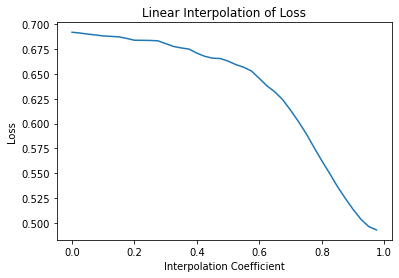

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

plt.savefig(os.path.join(run_path,'loss_lin_interpolation.png'))

In [22]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)

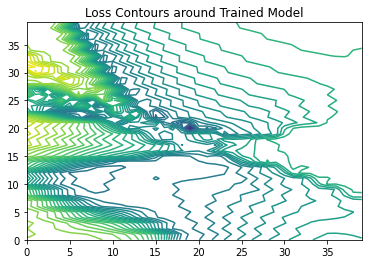

<Figure size 432x288 with 0 Axes>

In [23]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

plt.savefig(os.path.join(run_path,'loss_contour.png'))

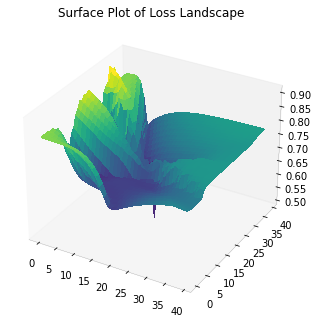

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
# ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo["grid"].update({"linewidth":0})

for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.line.set_linewidth(0.1)


ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',
                antialiased=False)
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

plt.savefig(os.path.join(run_path,'loss_landscape.png'))